#  ACTM SIMULATIONS

## Import Libraries

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## Define Helper Functions

In [12]:
def generate_demand(demand_type, K, ramp_indices, ramp_value_high, ramp_value_low, N):
    """
    Generates a demand matrix of shape (N, K) for on-ramp sections.
    For non on-ramp sections, demand remains zero.
    If ramp_value_low is None, then for each on-ramp:
      if index==11 then low=50 else low=100.
    """
    dem = np.zeros((N, K))
    # Set default low values if not provided.
    if ramp_value_low is None:
        ramp_low_dict = {i: (50 if i == 11 else 100) for i in ramp_indices}
    else:
        ramp_low_dict = {i: ramp_value_low for i in ramp_indices}
    
    if demand_type == "baseline":
        for k in range(100):
            for i in ramp_indices:
                dem[i, k] = ramp_value_high
        for k in range(100, K):
            for i in ramp_indices:
                dem[i, k] = ramp_low_dict[i]
    elif demand_type == "high_constant":
        for k in range(K):
            for i in ramp_indices:
                dem[i, k] = ramp_value_high
    elif demand_type == "low_constant":
        for k in range(K):
            for i in ramp_indices:
                dem[i, k] = ramp_low_dict[i]
    elif demand_type == "oscillatory":
        for k in range(K):
            demand_val = ramp_low_dict[ramp_indices[0]] + (ramp_value_high - ramp_low_dict[ramp_indices[0]]) * 0.5 * (1 + np.sin(2 * np.pi * k / K))
            for i in ramp_indices:
                dem[i, k] = demand_val
    elif demand_type == "step_change":
        for k in range(K):
            for i in ramp_indices:
                if k < K // 2:
                    dem[i, k] = ramp_low_dict[i]
                else:
                    dem[i, k] = ramp_value_high
    elif demand_type == "random":
        for k in range(100):
            for i in ramp_indices:
                baseline = ramp_value_high
                noise = np.random.normal(0, 100)
                dem[i, k] = max(0, baseline + noise)
        for k in range(100, K):
            for i in ramp_indices:
                baseline = ramp_low_dict[i]
                noise = np.random.normal(0, 50)
                dem[i, k] = max(0, baseline + noise)
    else:
        for k in range(100):
            for i in ramp_indices:
                dem[i, k] = ramp_value_high
        for k in range(100, K):
            for i in ramp_indices:
                dem[i, k] = ramp_low_dict[i]
    return dem


def run_simulation(N, K, T, L, rho_max, vf, w, rho_iniz, fi_iniz, 
                   rho_sez0, fi_sez0, rho_sezfin, fi_sezfin, dem, Ir, 
                   K_alinea, rho_ref, r_max_control):
    """
    Runs both the No Control (open-loop) and ALINEA Control (closed-loop) simulations.
    Returns a dictionary with simulation outputs for both cases:
      - "no_control": { "rho": rho_nc, "fi": fi_nc, "r": r_nc }
      - "alinea":    { "rho": rho_al, "fi": fi_al, "r": r_al }
    """
    # --- No Control Simulation ---
    rho_nc = np.zeros((N, K + 1))
    fi_nc = np.zeros((N, K))
    r_nc = dem.copy()  # Ramp flows follow the demand exactly.
    
    for i in range(N - 1):
        rho_nc[i, 0] = rho_iniz[i] + T / L[i] * (fi_iniz[i] - fi_iniz[i + 1])
    rho_nc[N - 1, 0] = rho_iniz[N - 1] + T / L[N - 1] * (fi_iniz[N - 1] - vf[N - 1] * rho_iniz[N - 1])
    
    for k in range(K):
        fi_nc[0, k] = min(fi_sez0[k], w[0] * (rho_max[0] - rho_nc[0, k]) - r_nc[0, k])
        for i in range(1, N):
            fi_nc[i, k] = min(vf[i - 1] * rho_nc[i - 1, k], w[i] * (rho_max[i] - rho_nc[i, k]) - r_nc[i, k])
        for i in range(N - 1):
            rho_nc[i, k + 1] = rho_nc[i, k] + T / L[i] * (fi_nc[i, k] + r_nc[i, k] - fi_nc[i + 1, k])
        outflow_nc = min(vf[N - 1] * rho_nc[N - 1, k], fi_sezfin[k])
        rho_nc[N - 1, k + 1] = rho_nc[N - 1, k] + T / L[N - 1] * (fi_nc[N - 1, k] + r_nc[N - 1, k] - outflow_nc)
    
    # --- ALINEA Control Simulation ---
    rho_al = np.zeros((N, K + 1))
    fi_al = np.zeros((N, K))
    r_al = dem.copy()  # Will be updated by ALINEA.
    
    for i in range(N - 1):
        rho_al[i, 0] = rho_iniz[i] + T / L[i] * (fi_iniz[i] - fi_iniz[i + 1])
    rho_al[N - 1, 0] = rho_iniz[N - 1] + T / L[N - 1] * (fi_iniz[N - 1] - vf[N - 1] * rho_iniz[N - 1])
    
    for k in range(K):
        for i in range(N):
            if Ir[i] == 1 and k > 0:
                r_al[i, k] = r_al[i, k - 1] + K_alinea * (rho_ref - rho_al[i, k])
                r_al[i, k] = np.clip(r_al[i, k], 0, r_max_control)
        fi_al[0, k] = min(fi_sez0[k], w[0] * (rho_max[0] - rho_al[0, k]) - r_al[0, k])
        for i in range(1, N):
            fi_al[i, k] = min(vf[i - 1] * rho_al[i - 1, k], w[i] * (rho_max[i] - rho_al[i, k]) - r_al[i, k])
        for i in range(N - 1):
            rho_al[i, k + 1] = rho_al[i, k] + T / L[i] * (fi_al[i, k] + r_al[i, k] - fi_al[i + 1, k])
        outflow_al = min(vf[N - 1] * rho_al[N - 1, k], fi_sezfin[k])
        rho_al[N - 1, k + 1] = rho_al[N - 1, k] + T / L[N - 1] * (fi_al[N - 1, k] + r_al[N - 1, k] - outflow_al)
    
    return {"no_control": {"rho": rho_nc, "fi": fi_nc, "r": r_nc},
            "alinea":    {"rho": rho_al, "fi": fi_al, "r": r_al}}


## Set Global Simulation Parameters and Boundary Conditions

In [13]:
# Global simulation parameters
N = 20
K = 360 * 2         # 2 hours simulation with 10-s sampling
T = 10 / 3600       # 10 seconds in hours
L = np.full(N, 0.5) # Section lengths (km)
w = np.full(N, 27)  # Congested wave speed

# Boundary conditions for the first and last sections.
default_rho_sez0_val = 60
default_rho_sezfin_val = 80
rho_sez0 = np.full(K, default_rho_sez0_val)
fi_sez0 = rho_sez0 * 100
rho_sezfin = np.full(K, default_rho_sezfin_val)
fi_sezfin = rho_sezfin * 100


## Define ALINEA Control Parameters

In [14]:
# ALINEA control parameters (common for all scenarios)
K_alinea = 50         # ALINEA gain (veh/h per (veh/km))
rho_ref = 60          # Target mainline density (veh/km)
r_max_control = 2000  # Maximum ramp metering rate (veh/h)


## Define Scenario Configurations

In [15]:
scenarios = [
    {"name": "Baseline",
     "demand_type": "baseline",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": None,
     "rho_iniz": 60,
     "vf": 100,
     "rho_max": 300},
    
    {"name": "High Constant Demand",
     "demand_type": "high_constant",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": 2000,
     "rho_iniz": 60,
     "vf": 100,
     "rho_max": 300},
    
    {"name": "Low Constant Demand",
     "demand_type": "low_constant",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 100,
     "ramp_value_low": 100,
     "rho_iniz": 60,
     "vf": 100,
     "rho_max": 300},
    
    {"name": "Oscillatory Demand",
     "demand_type": "oscillatory",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": 100,
     "rho_iniz": 60,
     "vf": 100,
     "rho_max": 300},
    
    {"name": "Additional On-ramp",
     "demand_type": "baseline",
     "ramp_indices": [4, 7, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": None,
     "rho_iniz": 60,
     "vf": 100,
     "rho_max": 300},
    
    {"name": "Lower Free-Flow Speed",
     "demand_type": "baseline",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": None,
     "rho_iniz": 60,
     "vf": 80,
     "rho_max": 300},
    
    {"name": "Lower Maximum Density",
     "demand_type": "baseline",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": None,
     "rho_iniz": 60,
     "vf": 100,
     "rho_max": 250},
    
    {"name": "Step Change in Demand",
     "demand_type": "step_change",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": 100,
     "rho_iniz": 60,
     "vf": 100,
     "rho_max": 300},
    
    {"name": "Random Demand Fluctuations",
     "demand_type": "random",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": 100,
     "rho_iniz": 60,
     "vf": 100,
     "rho_max": 300},
    
    {"name": "Higher Initial Density",
     "demand_type": "baseline",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": None,
     "rho_iniz": 80,
     "vf": 100,
     "rho_max": 300,
     "rho_sez0": 80,
     "rho_sezfin": 80}
]


## Step 6: Main Loop – Run Simulations and Create Plots

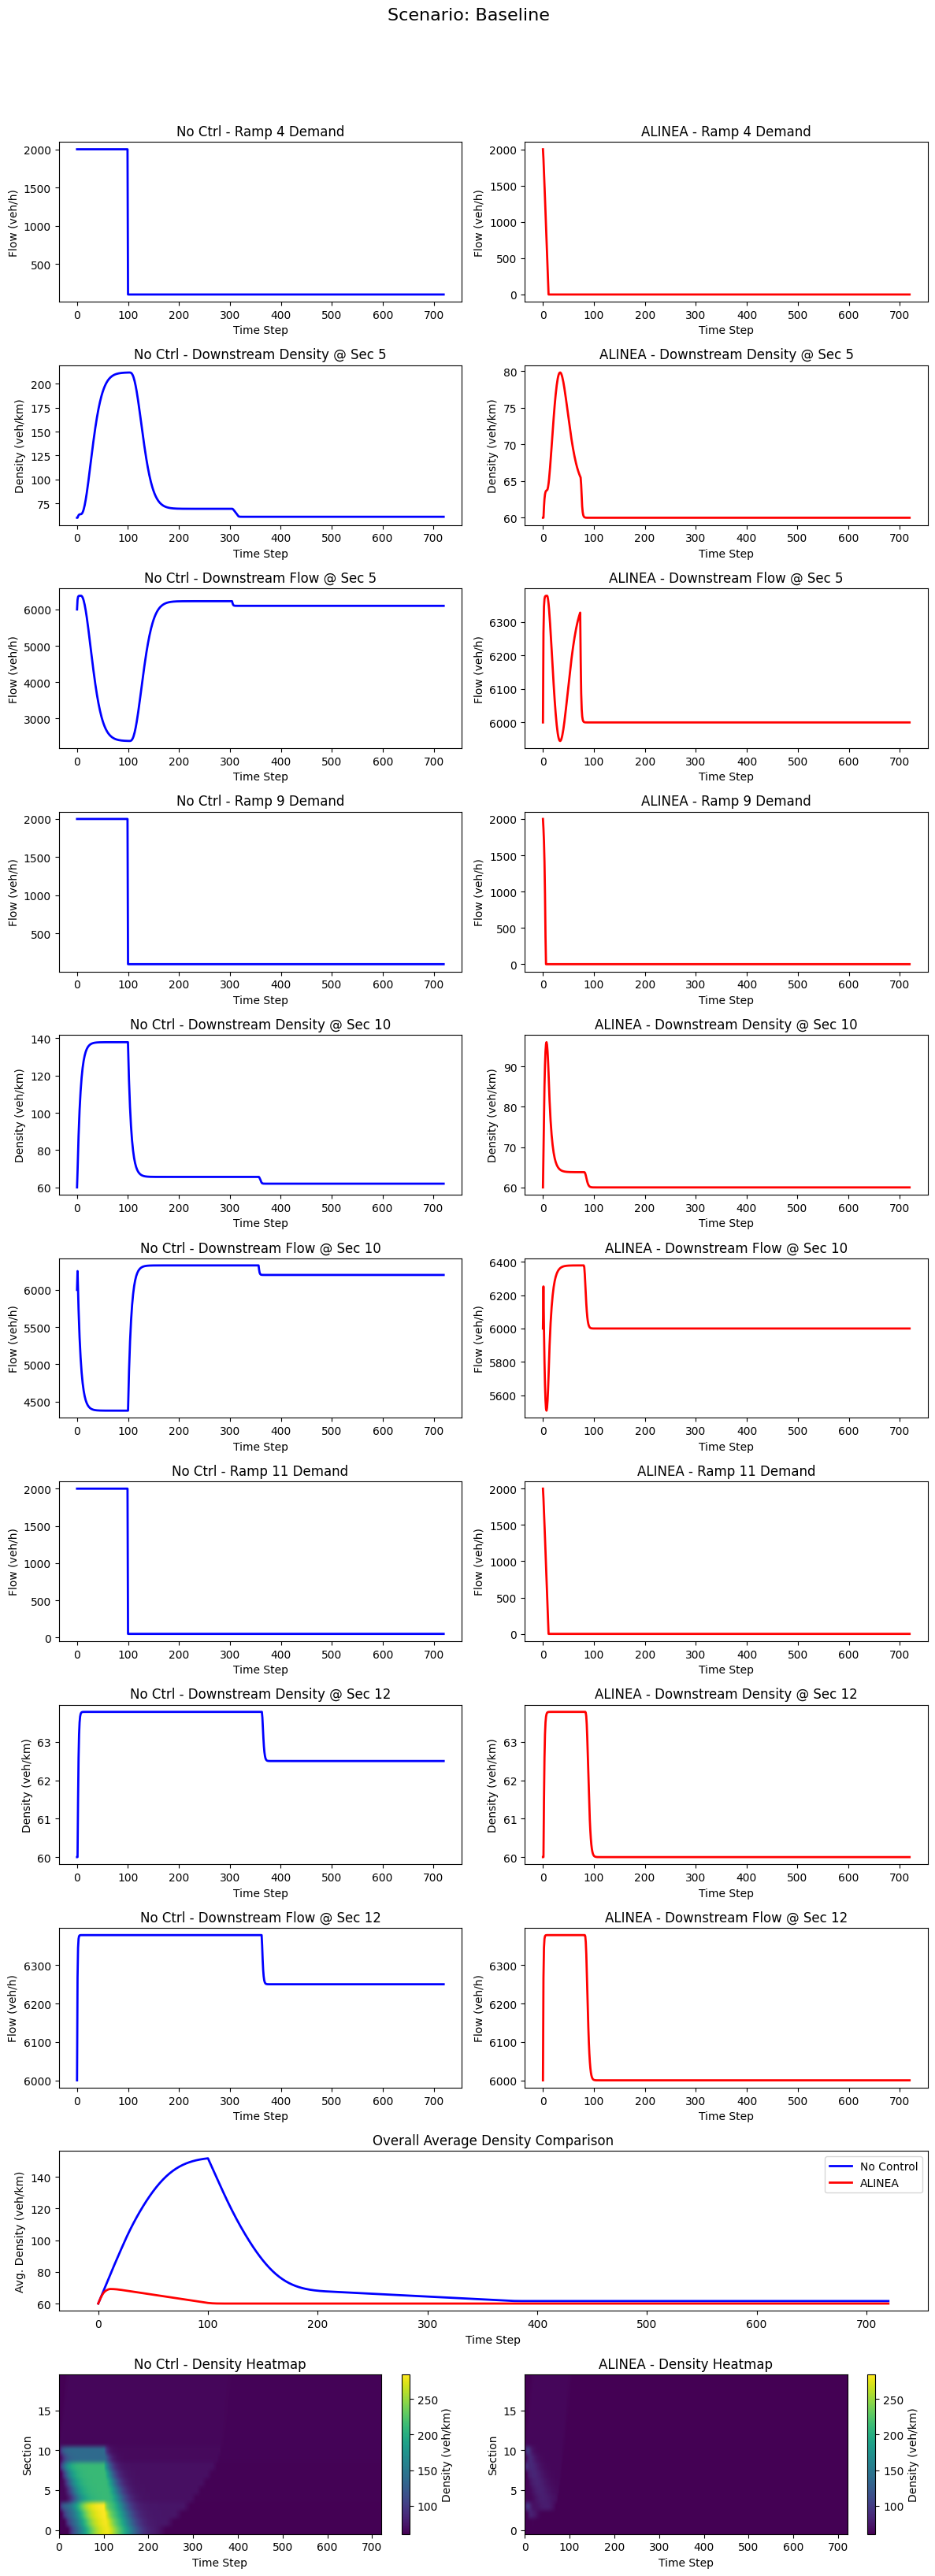

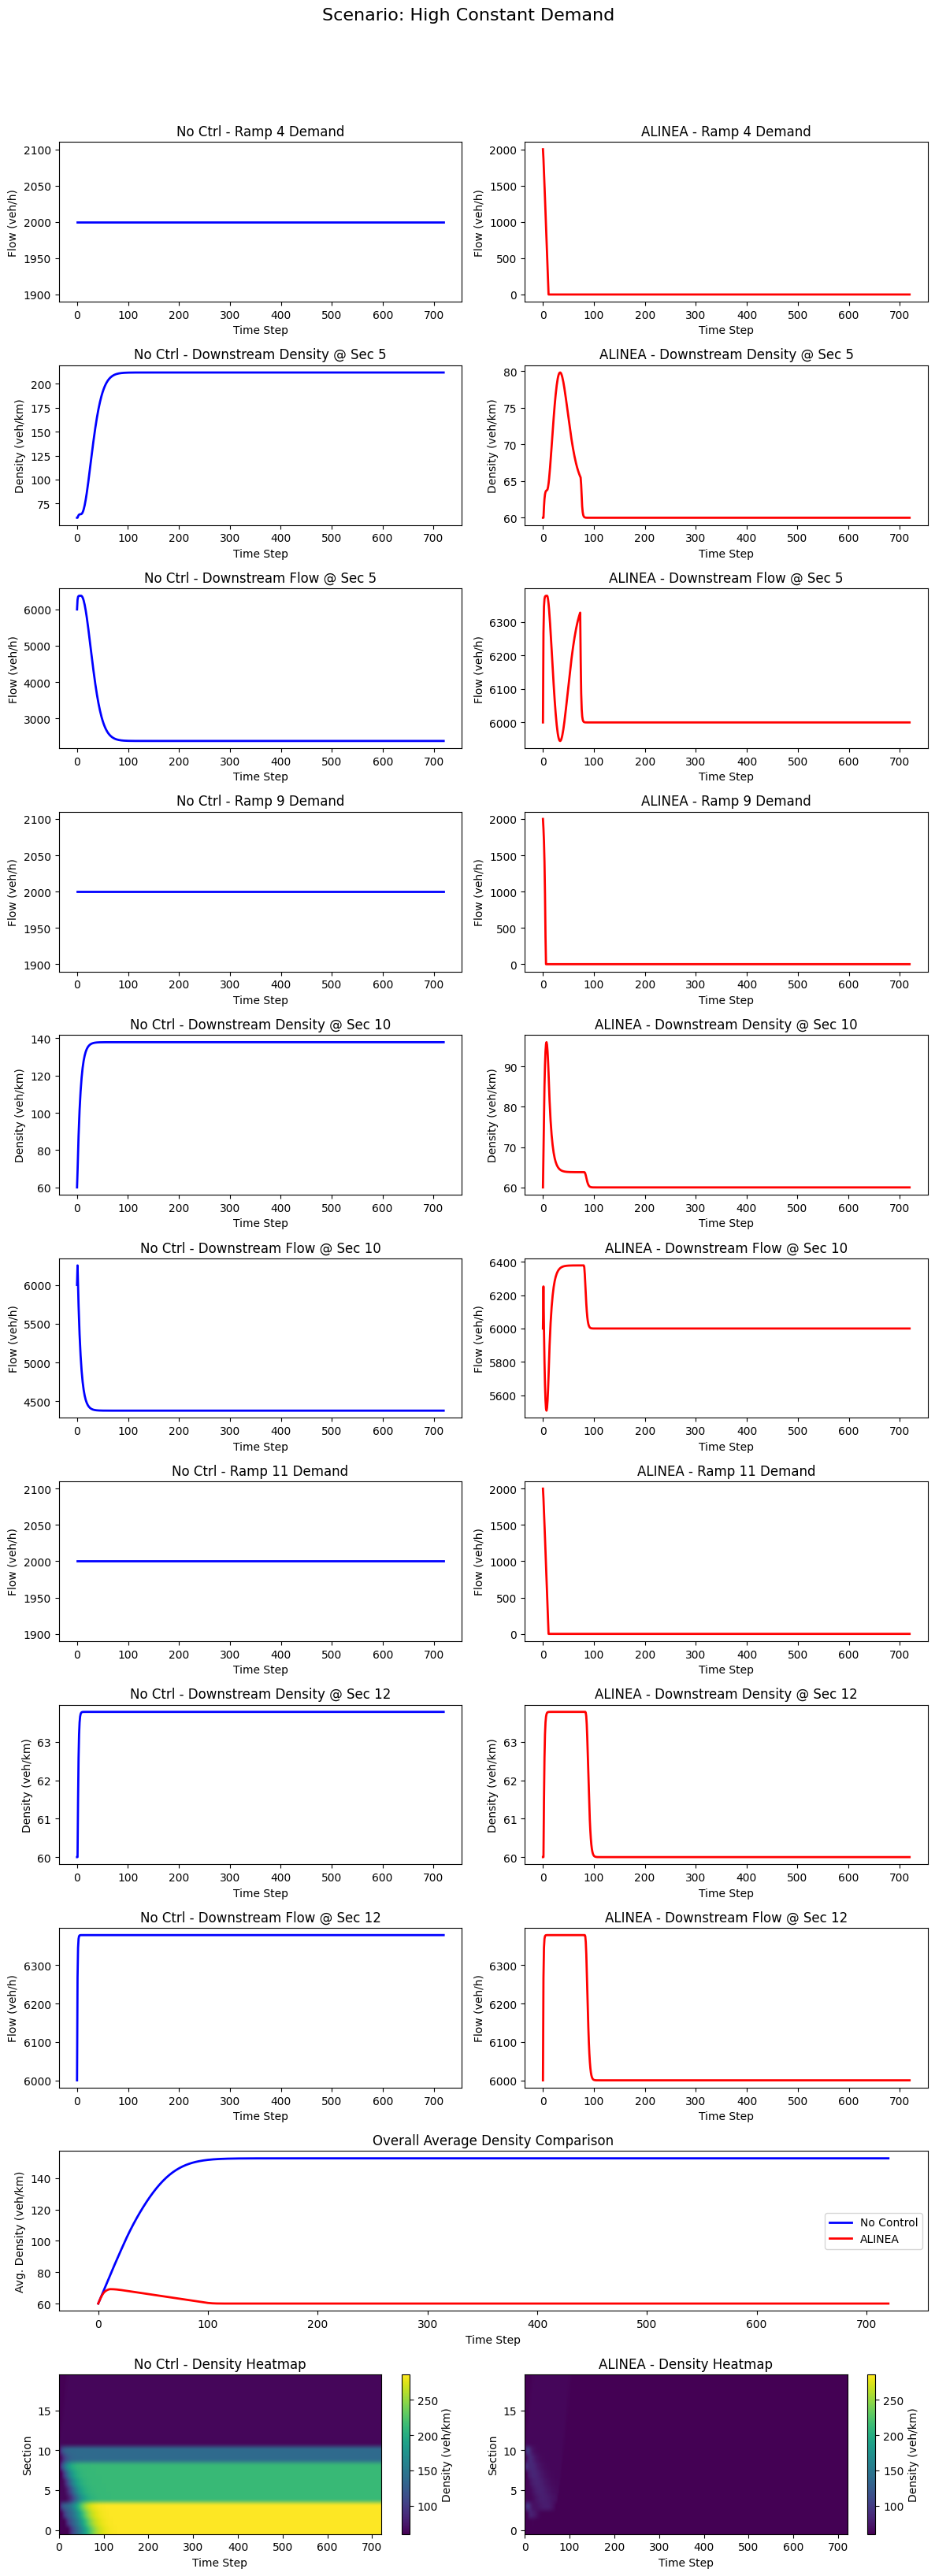

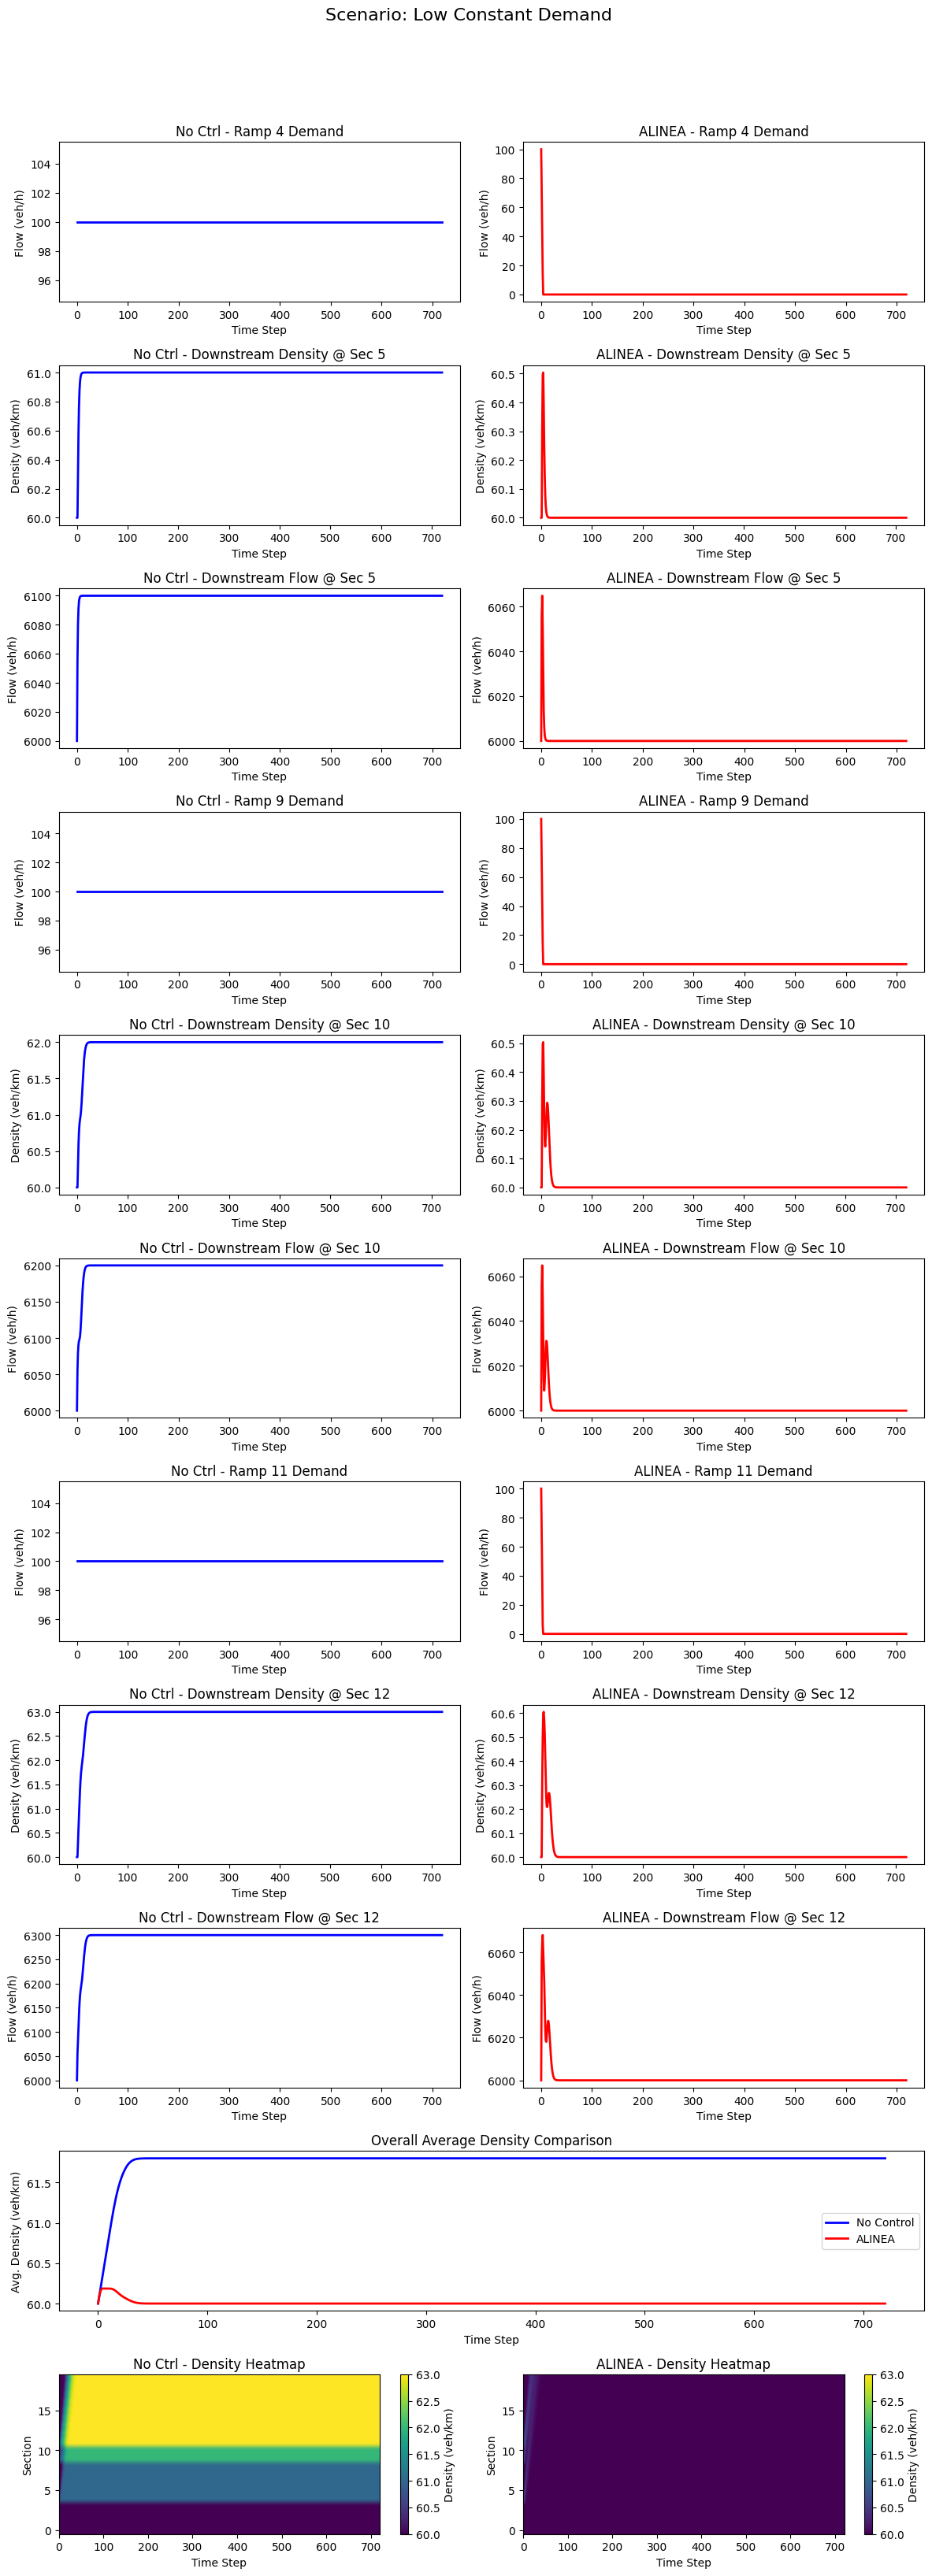

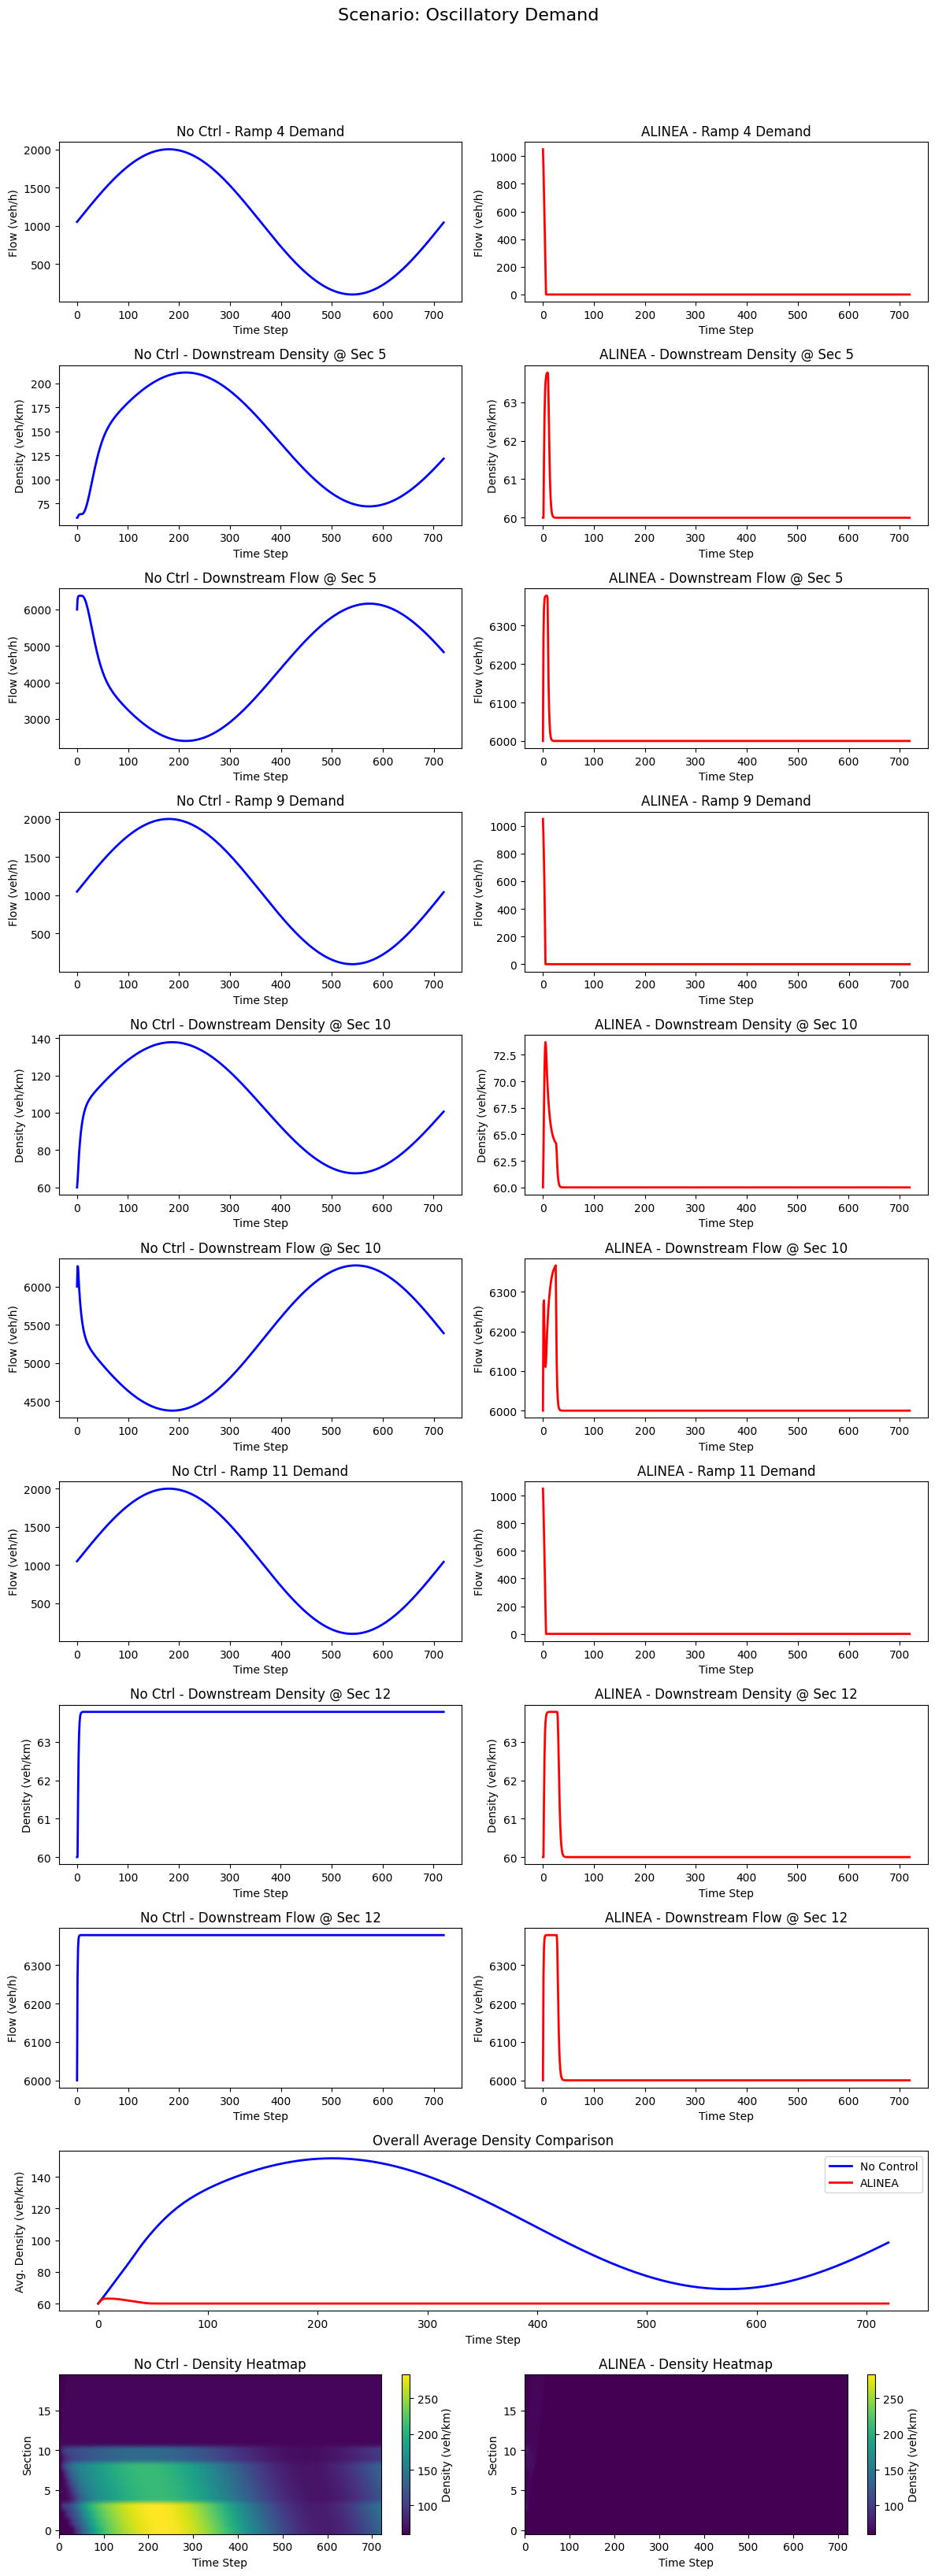

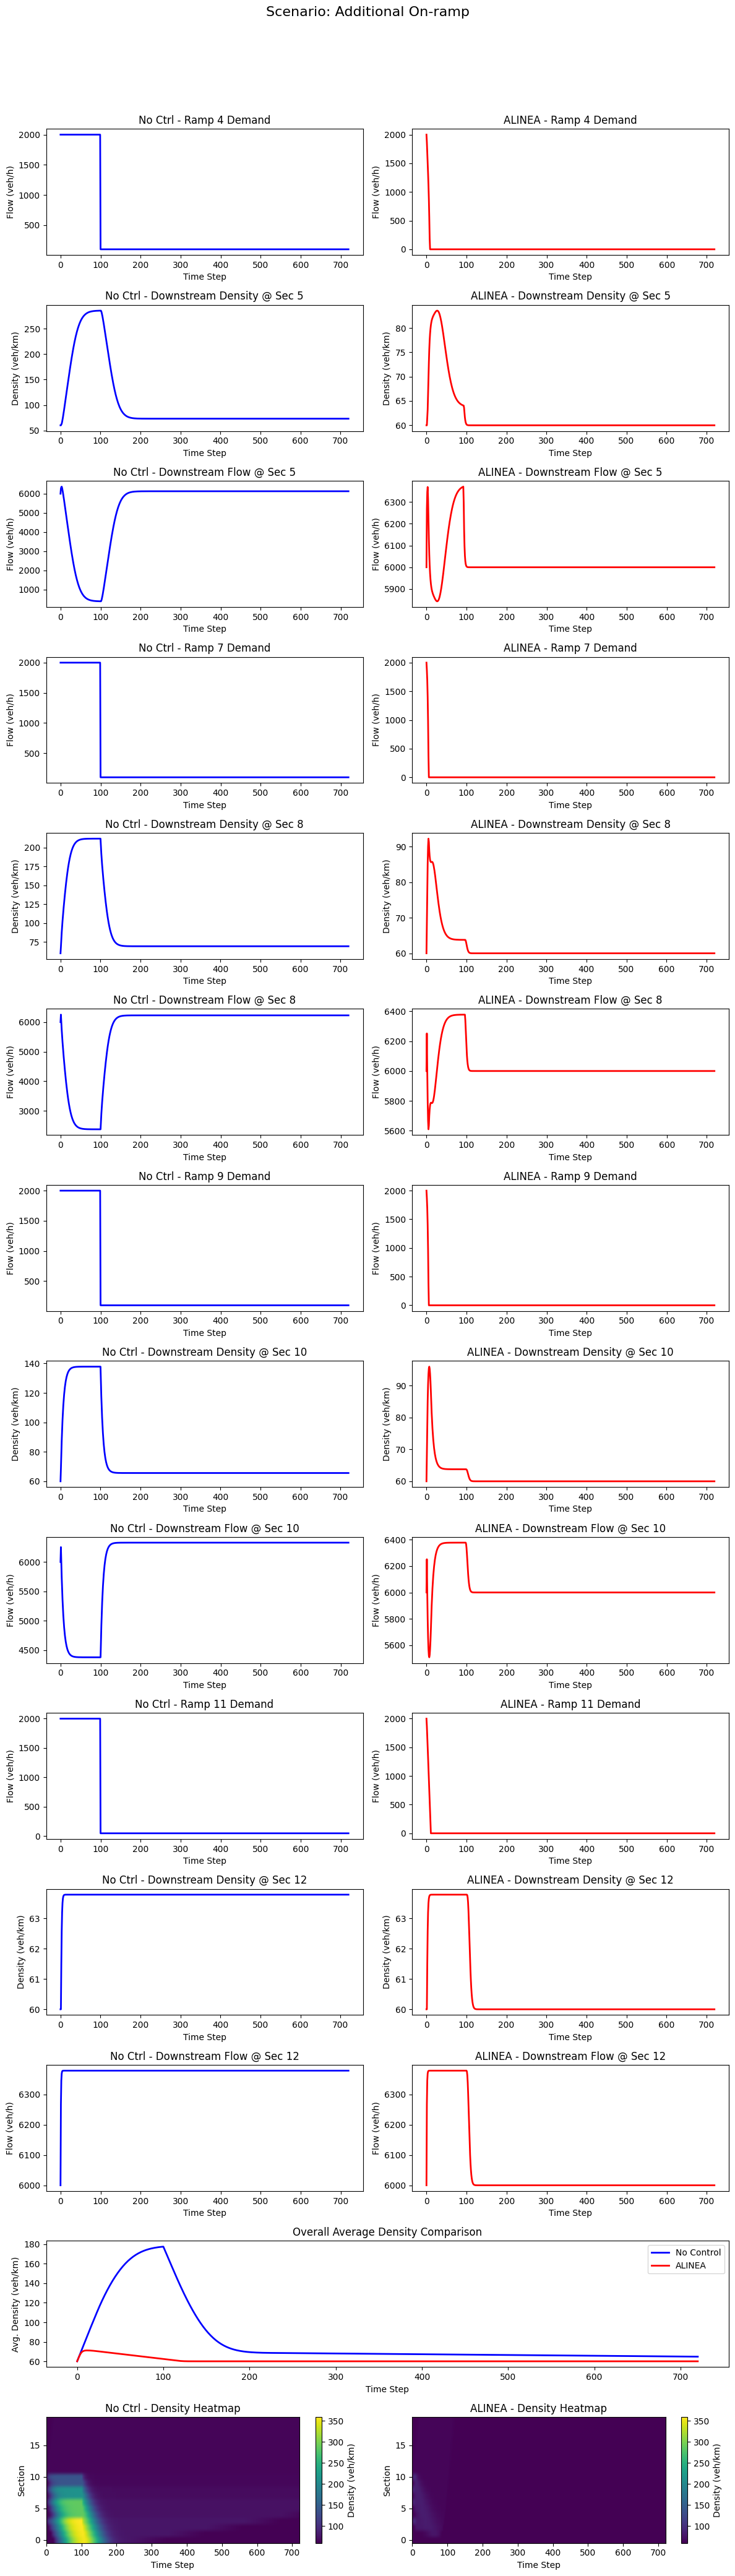

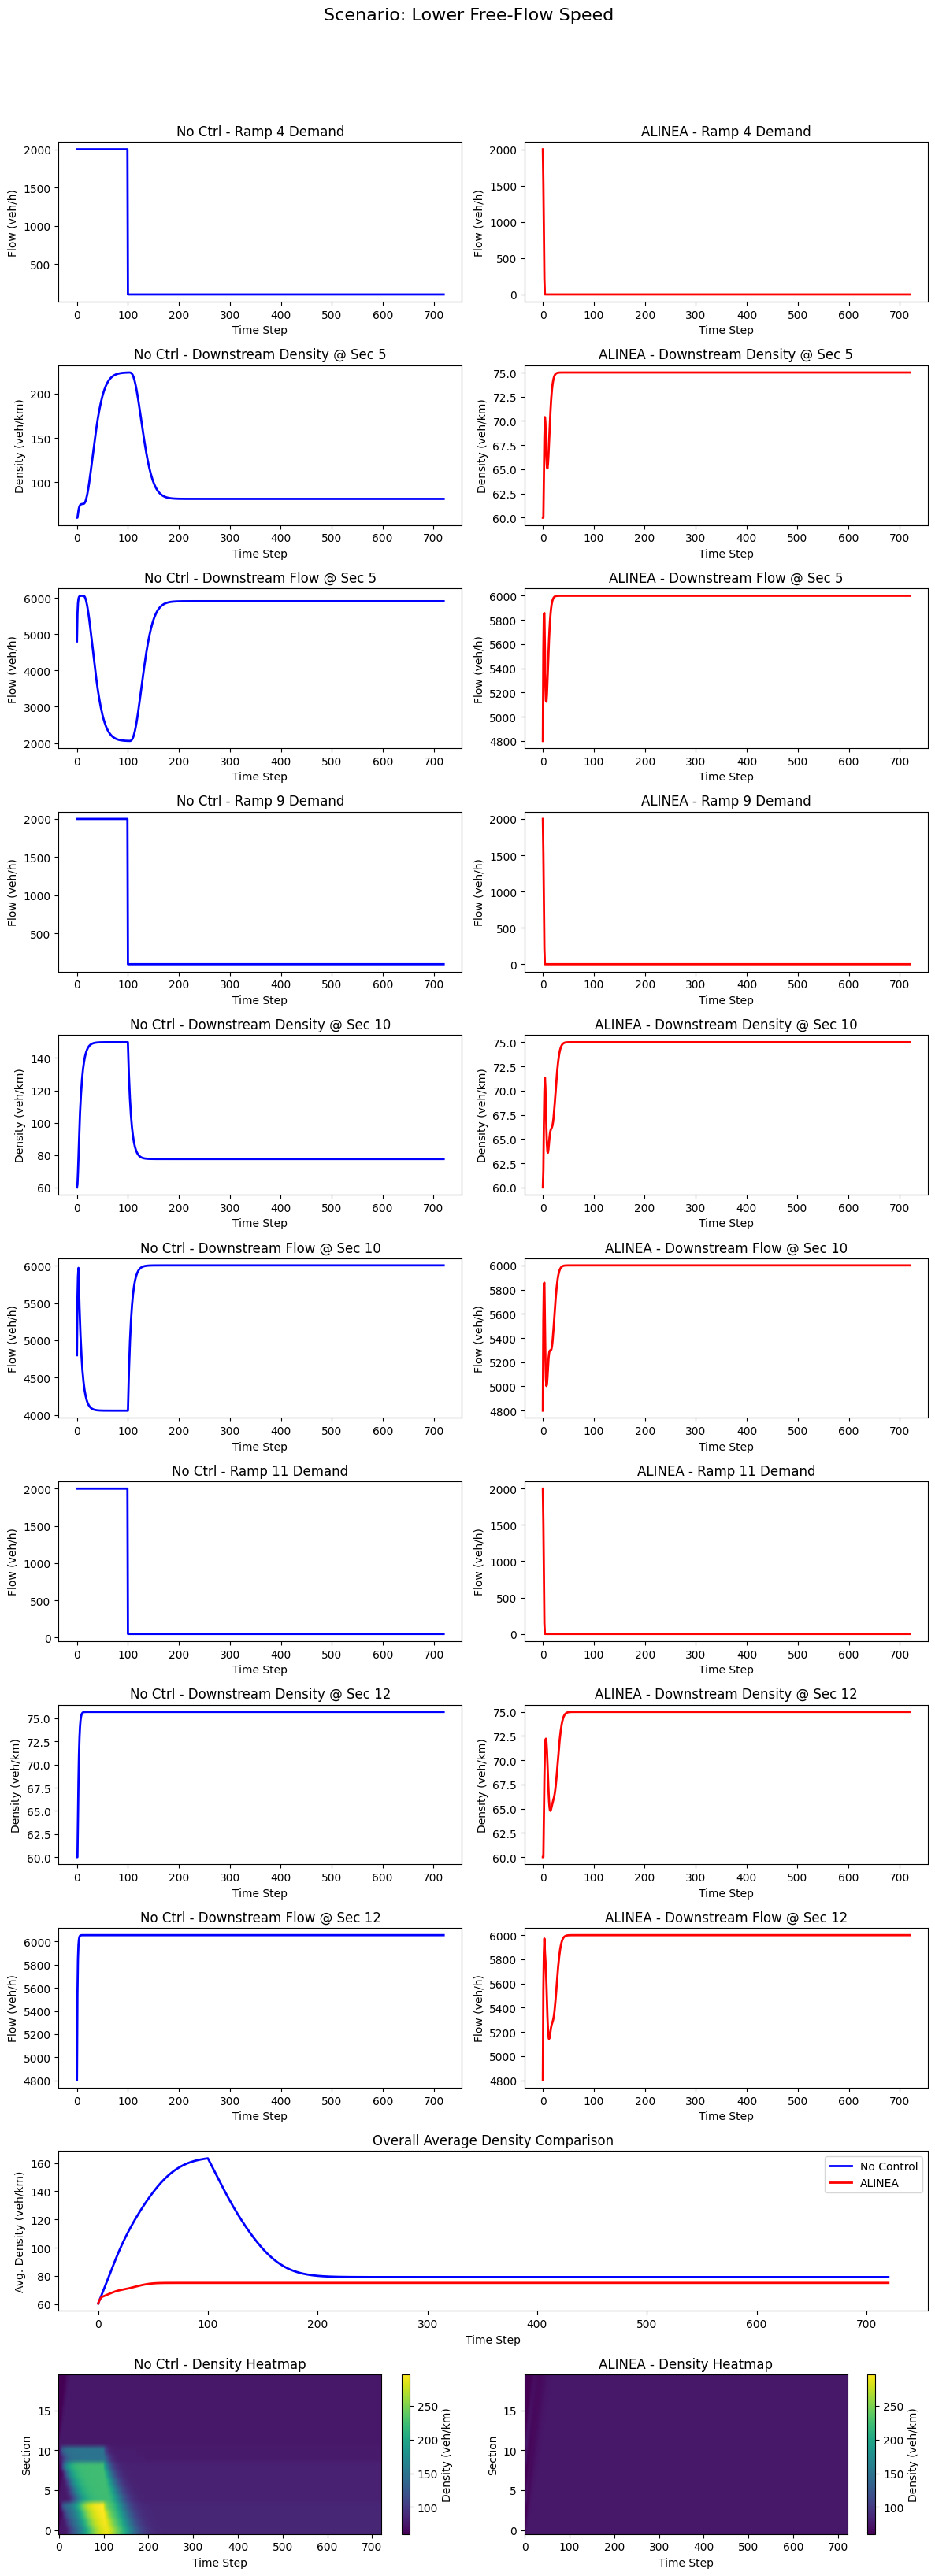

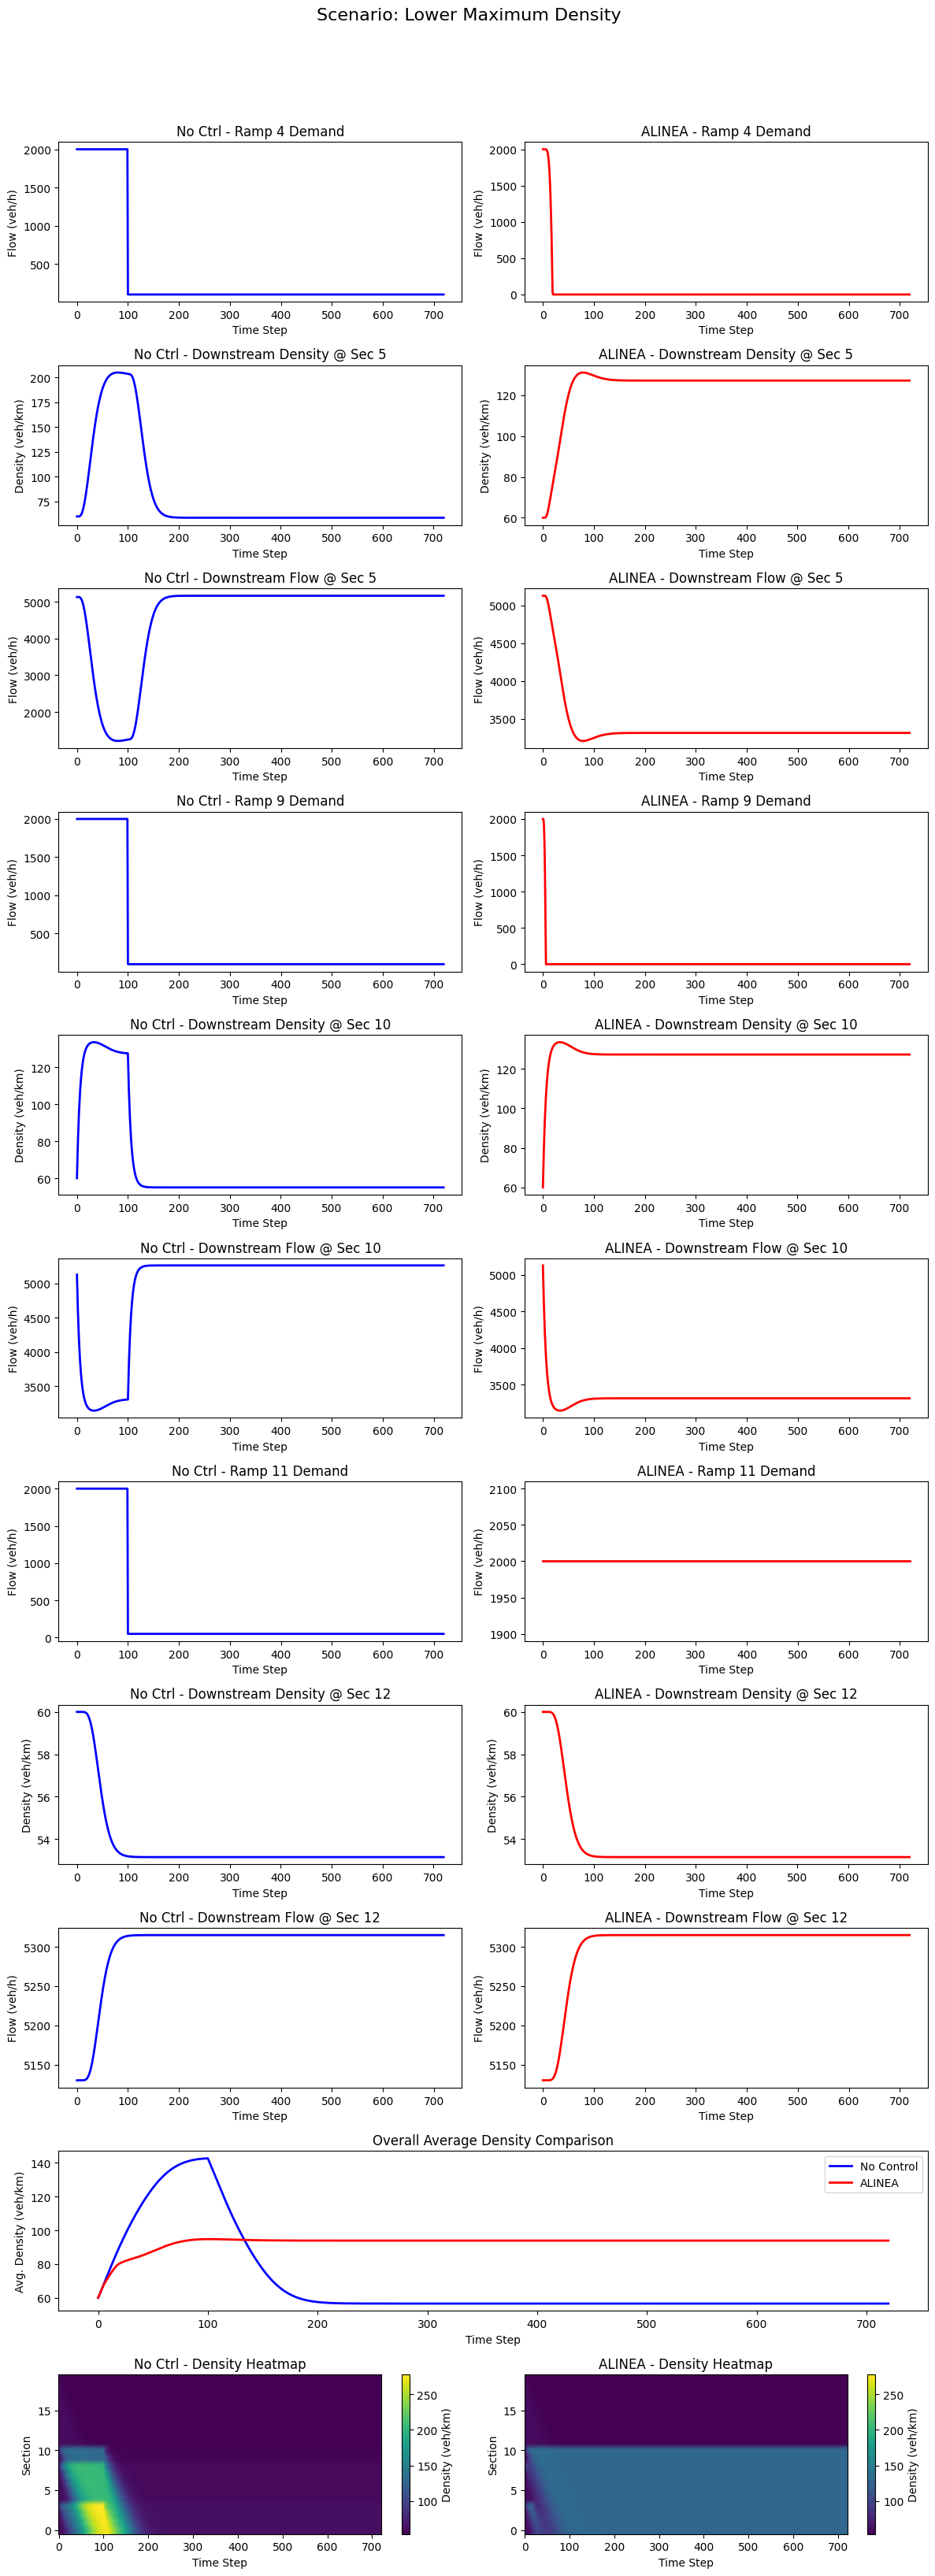

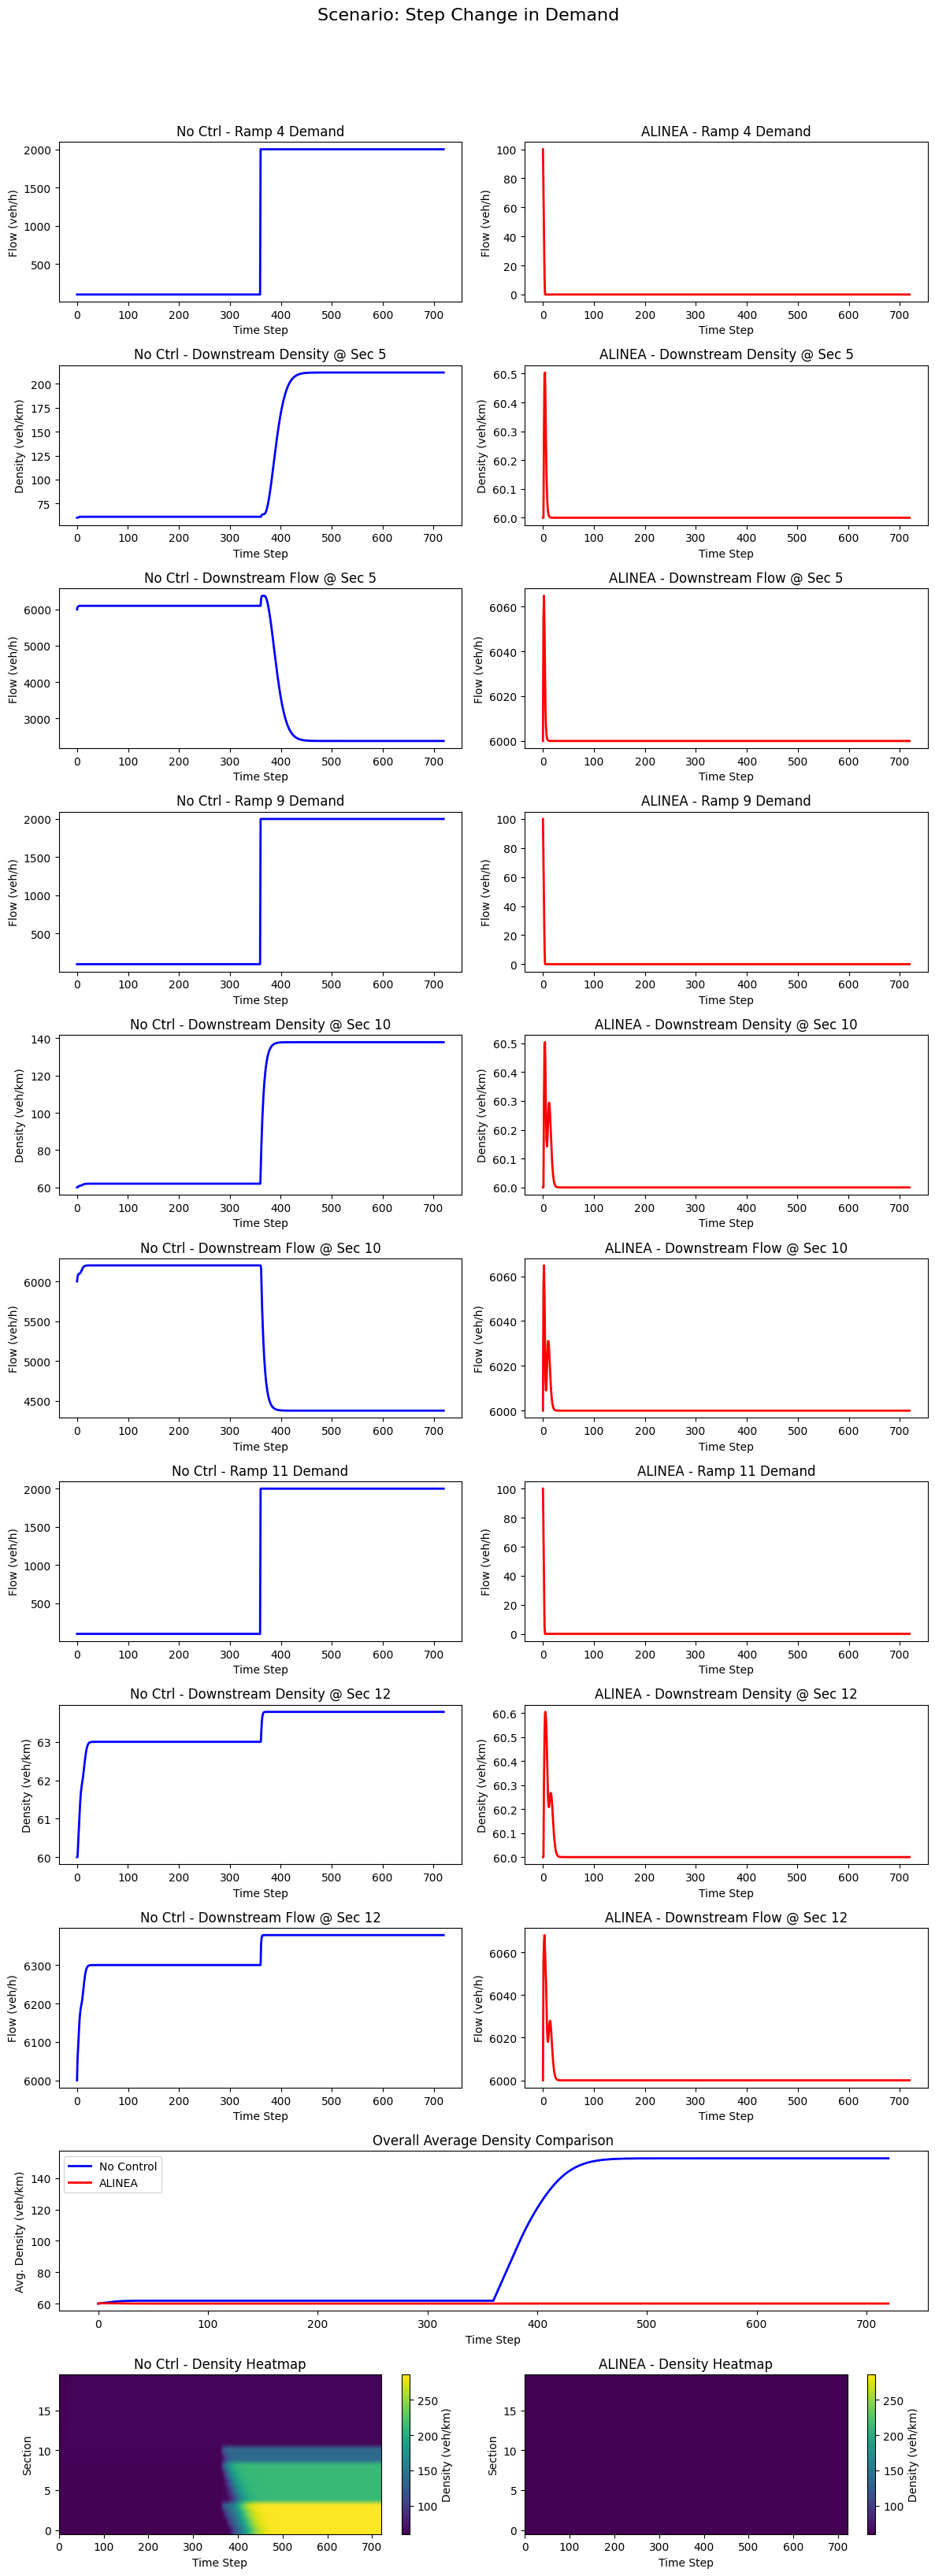

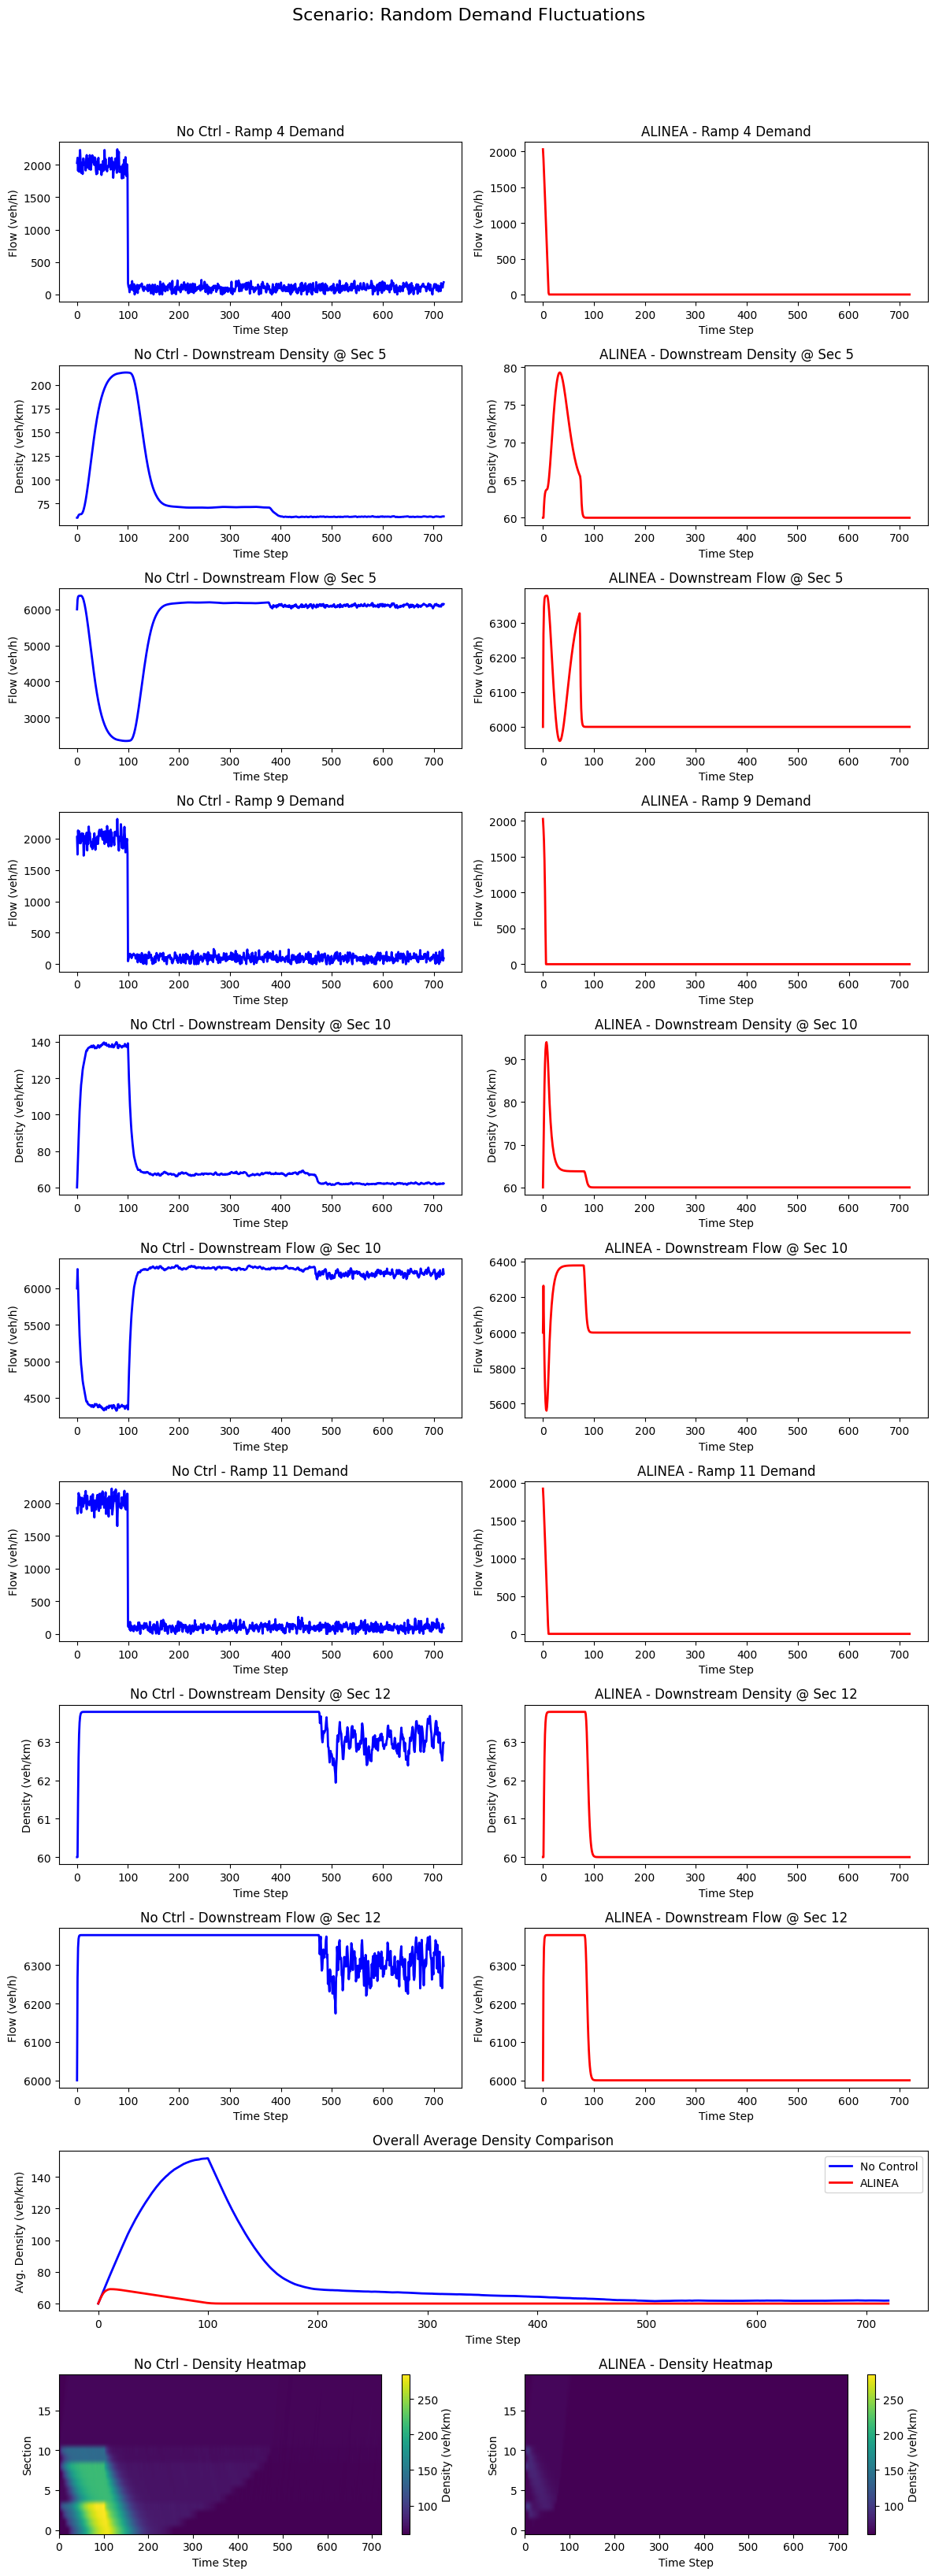

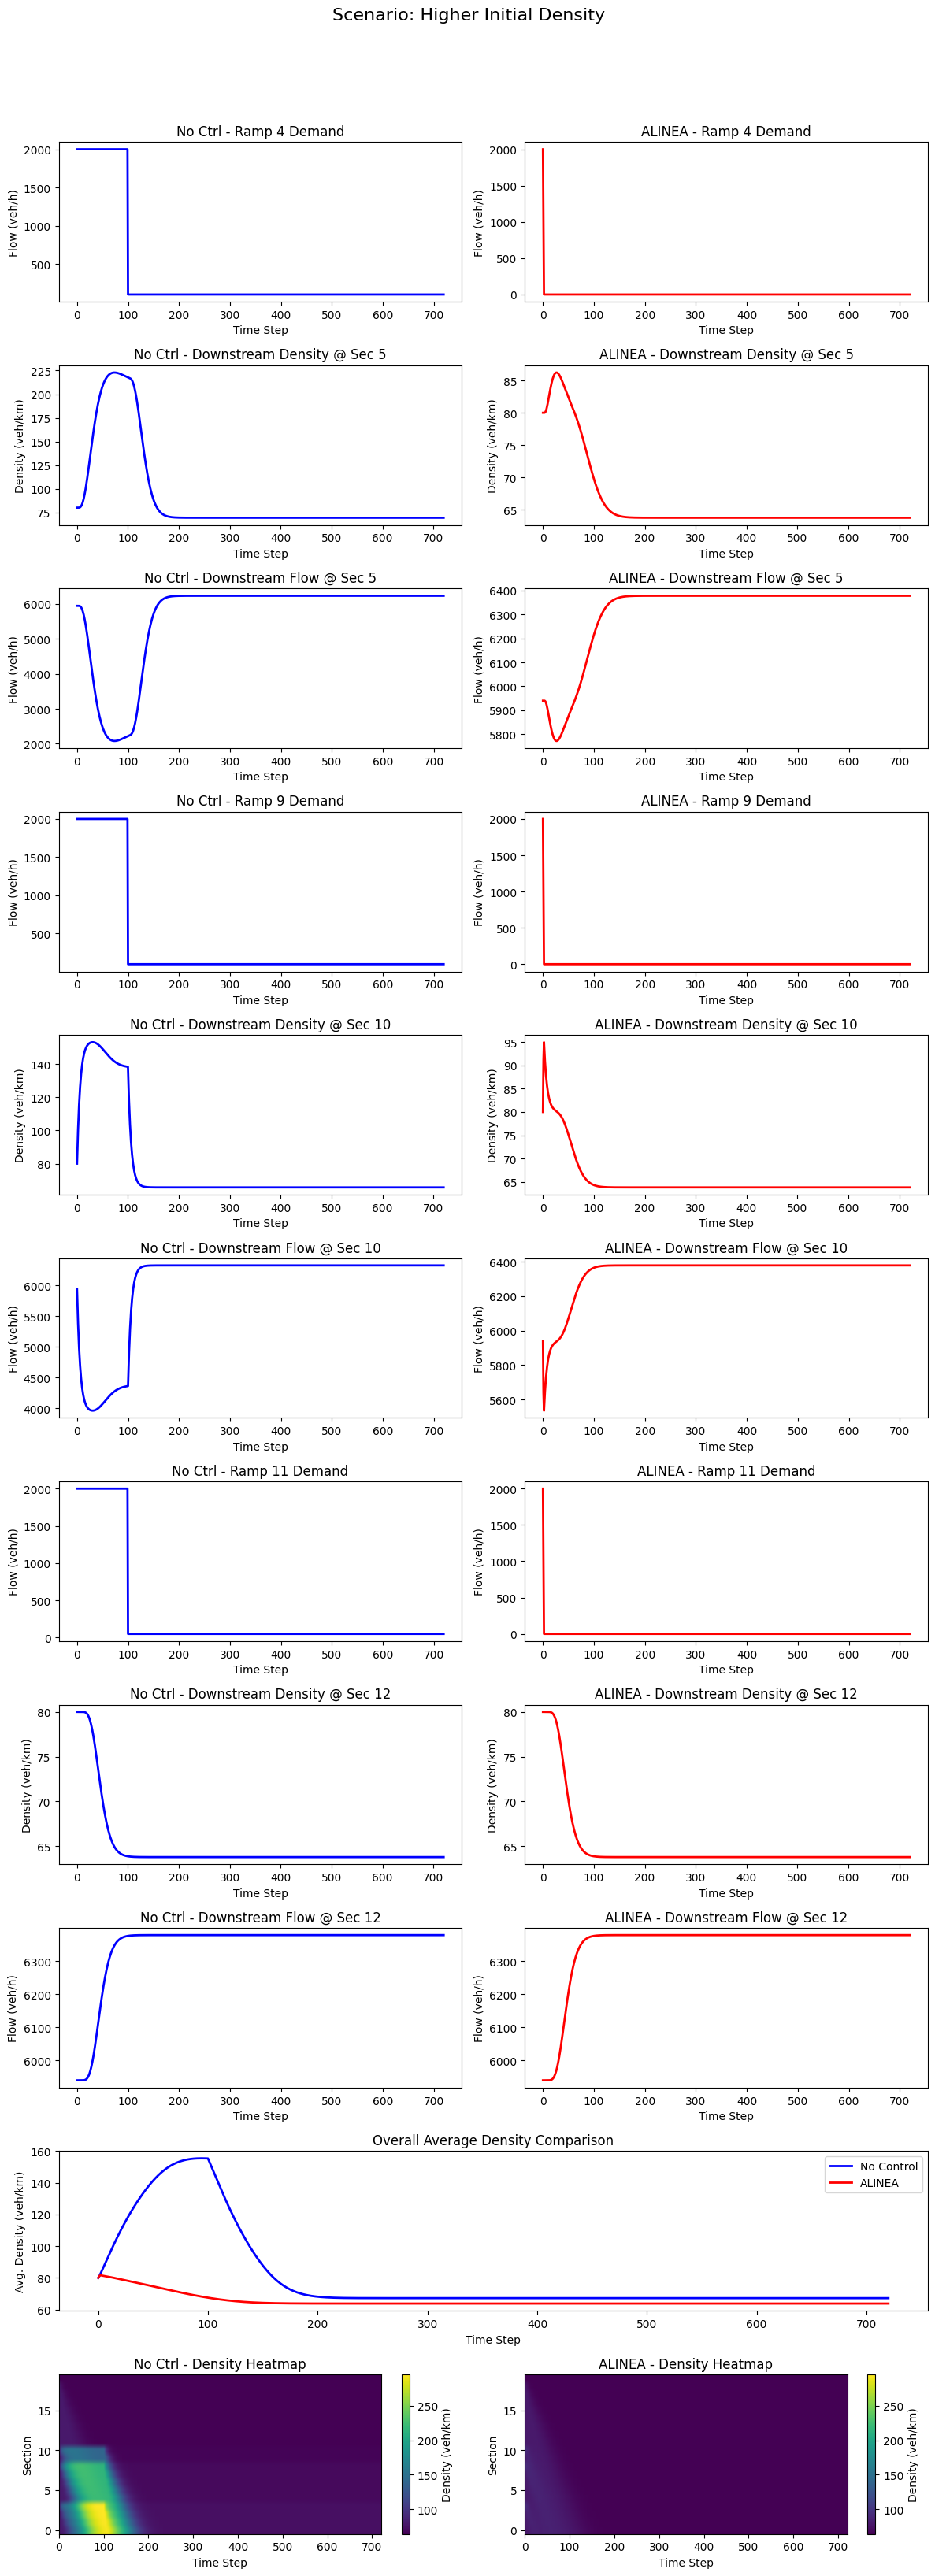

In [16]:
for scenario in scenarios:
    # Scenario-specific initial and boundary conditions.
    rho_iniz_val = scenario.get("rho_iniz", 60)
    rho_iniz = np.full(N, rho_iniz_val)
    fi_iniz = rho_iniz * 100
    
    rho_sez0_val = scenario.get("rho_sez0", default_rho_sez0_val)
    rho_sezfin_val = scenario.get("rho_sezfin", default_rho_sezfin_val)
    rho_sez0 = np.full(K, rho_sez0_val)
    fi_sez0 = rho_sez0 * 100
    rho_sezfin = np.full(K, rho_sezfin_val)
    fi_sezfin = rho_sezfin * 100
    
    vf_val = scenario.get("vf", 100)
    vf_arr = np.full(N, vf_val)
    rho_max_val = scenario.get("rho_max", 300)
    rho_max_arr = np.full(N, rho_max_val)
    
    ramp_indices = scenario["ramp_indices"]
    # On-ramp indicator.
    Ir = np.zeros(N)
    for i in ramp_indices:
        Ir[i] = 1
    
    # Generate demand.
    dem = generate_demand(
        demand_type=scenario["demand_type"],
        K=K,
        ramp_indices=ramp_indices,
        ramp_value_high=scenario["ramp_value_high"],
        ramp_value_low=scenario["ramp_value_low"],
        N=N
    )
    
    # Run simulations.
    sim_out = run_simulation(N, K, T, L, rho_max_arr, vf_arr, w, 
                             rho_iniz, fi_iniz, rho_sez0, fi_sez0, 
                             rho_sezfin, fi_sezfin, dem, Ir, 
                             K_alinea, rho_ref, r_max_control)
    no_ctrl = sim_out["no_control"]
    alinea = sim_out["alinea"]
    
    # Determine number of ramps and total rows.
    num_ramps = len(ramp_indices)
    # 3 rows per ramp block + 1 row for overall comparison + 1 row for heatmaps.
    total_rows = 3 * num_ramps + 1 + 1  
    
    # Create figure using GridSpec.
    fig = plt.figure(figsize=(12, 3 * total_rows))
    gs = gridspec.GridSpec(total_rows, 2, figure=fig)
    
    time_dem = np.arange(K)            # For demand and flow (length K)
    time_state = np.arange(K + 1)        # For density (length K+1)
    
    # Loop over each ramp.
    for j, ramp in enumerate(ramp_indices):
        ds_index = ramp + 1 if ramp < N - 1 else ramp
        
        # --- No Control Column ---
        ax_dem_nc = fig.add_subplot(gs[3*j, 0])
        ax_dem_nc.plot(time_dem, no_ctrl["r"][ramp, :], 'b-', linewidth=2)
        ax_dem_nc.set_title(f'No Ctrl - Ramp {ramp} Demand')
        ax_dem_nc.set_xlabel('Time Step')
        ax_dem_nc.set_ylabel('Flow (veh/h)')
        
        ax_den_nc = fig.add_subplot(gs[3*j + 1, 0])
        ax_den_nc.plot(time_state, no_ctrl["rho"][ds_index, :], 'b-', linewidth=2)
        ax_den_nc.set_title(f'No Ctrl - Downstream Density @ Sec {ds_index}')
        ax_den_nc.set_xlabel('Time Step')
        ax_den_nc.set_ylabel('Density (veh/km)')
        
        ax_flow_nc = fig.add_subplot(gs[3*j + 2, 0])
        if ramp < N - 1:
            downstream_flow = no_ctrl["fi"][ramp + 1, :]
        else:
            downstream_flow = np.minimum(vf_arr[-1] * no_ctrl["rho"][ramp, :K], fi_sezfin)
        ax_flow_nc.plot(np.arange(K), downstream_flow, 'b-', linewidth=2)
        ax_flow_nc.set_title(f'No Ctrl - Downstream Flow @ Sec {ds_index}')
        ax_flow_nc.set_xlabel('Time Step')
        ax_flow_nc.set_ylabel('Flow (veh/h)')
        
        # --- ALINEA Control Column ---
        ax_dem_al = fig.add_subplot(gs[3*j, 1])
        ax_dem_al.plot(time_dem, alinea["r"][ramp, :], 'r-', linewidth=2)
        ax_dem_al.set_title(f'ALINEA - Ramp {ramp} Demand')
        ax_dem_al.set_xlabel('Time Step')
        ax_dem_al.set_ylabel('Flow (veh/h)')
        
        ax_den_al = fig.add_subplot(gs[3*j + 1, 1])
        ax_den_al.plot(time_state, alinea["rho"][ds_index, :], 'r-', linewidth=2)
        ax_den_al.set_title(f'ALINEA - Downstream Density @ Sec {ds_index}')
        ax_den_al.set_xlabel('Time Step')
        ax_den_al.set_ylabel('Density (veh/km)')
        
        ax_flow_al = fig.add_subplot(gs[3*j + 2, 1])
        if ramp < N - 1:
            downstream_flow_al = alinea["fi"][ramp + 1, :]
        else:
            downstream_flow_al = np.minimum(vf_arr[-1] * alinea["rho"][ramp, :K], fi_sezfin)
        ax_flow_al.plot(np.arange(K), downstream_flow_al, 'r-', linewidth=2)
        ax_flow_al.set_title(f'ALINEA - Downstream Flow @ Sec {ds_index}')
        ax_flow_al.set_xlabel('Time Step')
        ax_flow_al.set_ylabel('Flow (veh/h)')
    
    # --- Overall Average Density Comparison ---
    overall_row = 3 * num_ramps
    ax_overall = fig.add_subplot(gs[overall_row, :])
    avg_nc = np.mean(no_ctrl["rho"], axis=0)
    avg_al = np.mean(alinea["rho"], axis=0)
    ax_overall.plot(time_state, avg_nc, 'b-', label='No Control', linewidth=2)
    ax_overall.plot(time_state, avg_al, 'r-', label='ALINEA', linewidth=2)
    ax_overall.set_title('Overall Average Density Comparison')
    ax_overall.set_xlabel('Time Step')
    ax_overall.set_ylabel('Avg. Density (veh/km)')
    ax_overall.legend()
    
    # --- Density Heatmaps ---
    heatmap_row = overall_row + 1
    global_min = min(np.min(no_ctrl["rho"]), np.min(alinea["rho"]))
    global_max = max(np.max(no_ctrl["rho"]), np.max(alinea["rho"]))
    
    ax_heat_nc = fig.add_subplot(gs[heatmap_row, 0])
    im_nc = ax_heat_nc.imshow(no_ctrl["rho"], aspect='auto', origin='lower', 
                               vmin=global_min, vmax=global_max)
    ax_heat_nc.set_title('No Ctrl - Density Heatmap')
    ax_heat_nc.set_xlabel('Time Step')
    ax_heat_nc.set_ylabel('Section')
    fig.colorbar(im_nc, ax=ax_heat_nc, label='Density (veh/km)')
    
    ax_heat_al = fig.add_subplot(gs[heatmap_row, 1])
    im_al = ax_heat_al.imshow(alinea["rho"], aspect='auto', origin='lower', 
                               vmin=global_min, vmax=global_max)
    ax_heat_al.set_title('ALINEA - Density Heatmap')
    ax_heat_al.set_xlabel('Time Step')
    ax_heat_al.set_ylabel('Section')
    fig.colorbar(im_al, ax=ax_heat_al, label='Density (veh/km)')
    
    fig.suptitle(f"Scenario: {scenario['name']}", fontsize=16, y=0.99)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
